In [14]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import cv2
import random
random.seed(42)
from sklearn.preprocessing import normalize
import pickle

from scipy.spatial import distance

In [15]:
HOME="./Faces_FA_FB/"
fa_H="fa_H"
fa_L="fa_L"
fb_H="fb_H"
fb_L="fb_L"

training_location_H=HOME+"/"+fa_H
testing_location_H=HOME+"/"+fb_H
training_location_L=HOME+"/"+fa_L
testing_location_L=HOME+"/"+fb_L

In [16]:
def get_images_id(location):
    images_name=[]
    for file in os.listdir(location):
        if file.endswith(".pgm"):
            images_name.append(file)

    data_id=np.array([x[:5] for x in images_name])
    images=np.array([cv2.imread(location+"/"+x) for x in images_name])
    return images,data_id

training_images_H,training_data_id_H=get_images_id(training_location_H)
testing_images_H,testing_data_id_H=get_images_id(testing_location_H)
training_images_L,training_data_id_L=get_images_id(training_location_L)
testing_images_L,testing_data_id_L=get_images_id(testing_location_L)


In [17]:
np.sum(np.array([1 for a in testing_data_id_L if int(a)<=140]))

84

In [18]:
def show_multiple_images_10(images,title=None):
    rows=int(len(images)/5)
    if rows%1>0:
        rows=rows+1
    columns=5
    fig = plt.figure(figsize=(1.5*columns,1.5*rows))
    if title:
        fig.suptitle(title,fontsize=10)
    
    for i in range(len(images)):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(images[i],cmap='gray')
        plt.axis('off')
        plt.savefig("a_I_largest_10.svg",dpi=300,format='svg')
        

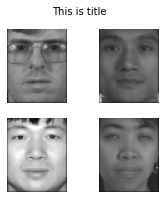

In [19]:
def show_multiple_images(images,title=None):
    rows=int(len(images)/2)
    if rows%1>0:
        rows=rows+1
    columns=2
    fig = plt.figure(figsize=(1.5*columns,1.5*rows))
    if title:
        fig.suptitle(title,fontsize=10)
    
    for i in range(len(images)):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(images[i],cmap='gray')
        plt.axis('off')
        
show_multiple_images(training_images_H[:4]/255,"This is title")

In [20]:
class MyPCA_testing:
    
    def __init__(self, read_pickle_model, information=100):
        self.read_pickle_model=read_pickle_model
        self.information=information
        self.find_components()
        
    def find_components(self):        
        with open(self.read_pickle_model,'rb') as filehandler:
            object_file = pickle.load(filehandler)
        self.projections,self.mean,self.eig_vals_sorted,self.eig_vecs_sorted,self.data_id=object_file
        
        image_shape=np.array(self.mean).shape
#         self.mean=np.array(self.mean).flatten()
        #Finding n_components from teh amount of information to take
        if self.information>1:
            self.information=self.information/100
        if self.information!=None:
            info_cumsum=np.cumsum(self.eig_vals_sorted)
            
            info_cumsum_percent=np.array(info_cumsum)/info_cumsum[-1]
            for i in range(len(info_cumsum)):
                if info_cumsum_percent[i]>=self.information:
                    self.n_components=i
                    break
                    
        self.components =self. eig_vecs_sorted[:self.n_components]
        self.eign_val_components = self.eig_vals_sorted[:self.n_components]
        self.projections=self.projections[:,:self.n_components]
    
    def distance_with_faces(self,x):
#         distances=np.array([np.sum(np.square(x-a)/self.eign_val_components) for a in self.projections])
        inverse_eigen_val_matrix=np.diag(1/self.eign_val_components)
        print(x.shape,self.projections[0].shape,inverse_eigen_val_matrix.shape)
        distances=[distance.mahalanobis(x,a,inverse_eigen_val_matrix) for a in self.projections]
        return distances
        
    def predict_a_face(self, item, r):
        P = item[:,:,0].copy()
        P = (P - self.mean).flatten()
        P_proj=self.components.dot(P)
        
        distances=self.distance_with_faces(P_proj)
        sorted_arg=np.argsort(distances)
        args_to_see=sorted_arg[:r]
        np.array([self.data_id[x] for x in args_to_see])
        
    def predict_intrusion(self,item,threshold):
        P = item[:,:,0].copy()
        P = (P - self.mean).flatten()
        P_proj=self.components.dot(P)
        
        distance=self.distance_with_faces(P_proj)[0]
        if distance>threshold:
            return 0
        else:
            return 1
        
    
    def getMean(self):
        return self.mean
    
    def getComponents(self):
        return self.components
    
    def getProjections(self):
        return self.projections
    
    def getDataId(self):
        return self.data_id

In [21]:
PCA1=MyPCA_testing(read_pickle_model="High_50_images.pickle",information=80)
prediction=[PCA1.predict_intrusion(testing_images_H[i],0.1) for i in range(len(testing_data_id_H))]
non_intruders=PCA1.getDataId()
truth_value=np.array([1 if testing_data_id_H[i] in non_intruders else 0 for i in range(len(testing_data_id_H)) ])
intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
FPR=np.sum(1-intruders_predicted_set)/len(intruders_predicted_set)
non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]
TPR=np.sum(np.array(non_intruders_predicted_set))/len(non_intruders)
FPR,TPR

(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (

(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (

(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (17, 17)
(17,) (17,) (

(1.0, 0.0008936550491510277)

In [22]:
def create_ROC(model,testing_images,testing_data_id,title):
    non_intruders=PCA1.getDataId()
    truth_value=np.array([1 if testing_data_id[i] in non_intruders else 0 for i in range(len(testing_data_id))])
    FPR=[]
    TPR=[]
    for threshold in np.arange(0.01,1,0.05):
        prediction=[PCA1.predict_intrusion(testing_images[i],threshold) for i in range(len(testing_data_id))]
        intruders_predicted_set=np.array([e for i ,e in enumerate(prediction) if truth_value[i]==0])
        FPRx=np.sum(intruders_predicted_set)/len(intruders_predicted_set)
        non_intruders_predicted_set=[e for i ,e in enumerate(prediction) if truth_value[i]==1]
        TPRx=np.sum(np.array(non_intruders_predicted_set))/len(non_intruders)
        FPR.append(FPRx)
        TPR.append(TPRx)
    print(FPR,TPR)
    plt.plot(FPR,TPR)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()
        


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)
(116,) (116,) (116, 116)


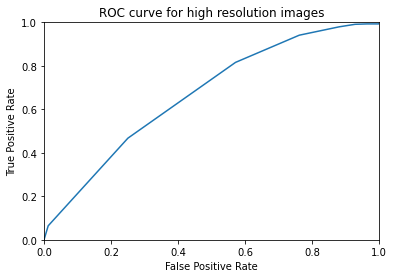

In [23]:
PCA1=MyPCA_testing(read_pickle_model="High_50_images.pickle",information=95)       
create_ROC(model=PCA1,
           testing_images=testing_images_H,
           testing_data_id=testing_data_id_H,
           title="ROC curve for high resolution images"
          )       

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (40, 40)
(40,) (40,) (

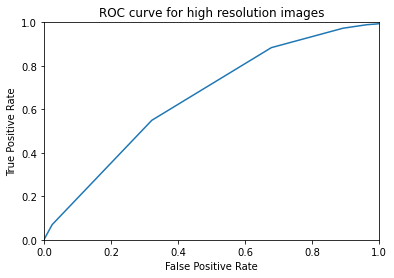

In [24]:
PCA1=MyPCA_testing(read_pickle_model="Low_50_images.pickle",information=95)       
create_ROC(model=PCA1,
           testing_images=testing_images_L,
           testing_data_id=testing_data_id_L,
           title="ROC curve for high resolution images"
          )       